In [135]:
import h5py
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from pathlib import Path

from rat_moseq.io import load_downsampled_rat
from rat_moseq.behavior import compute_rps_autocorr, get_rps, mask_frame, compute_tau_df
from rat_moseq.organization import get_mouse_h5s
from rat_moseq.plotting import format_plots
format_plots()

# get mouse autocorr df

In [3]:
mouse_h5s = get_mouse_h5s()
mouse_h5s = [h5 for h5 in mouse_h5s if 'saline' in str(h5)]

mouse_ac = []
for h5 in tqdm(mouse_h5s, total=len(mouse_h5s)):
    frames = h5py.File(h5, 'r')['frames'][()]
    frames = mask_frame(frames)
    rps = get_rps(frames)
    ac = compute_rps_autocorr(rps)
    ac['animal'] = h5.name
    mouse_ac.append(ac)
mouse_ac = pd.concat(mouse_ac)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [03:45<00:00,  9.38s/it]


# get rat autocorr df

In [5]:
resized_path = '/n/groups/datta/jlove/data/rat_seq/rat_seq_paper/analysis/resized_rat.h5'

resized = load_downsampled_rat(resized_path)

In [8]:
rat_ac = []
for k, v in tqdm(resized.items(), total=len(resized)):
    rps = get_rps(v)
    ac = compute_rps_autocorr(rps)
    ac['animal'] = k
    rat_ac.append(ac)
rat_ac = pd.concat(rat_ac)

100%|██████████| 46/46 [02:53<00:00,  3.77s/it]


# get dead rat autocorr df

In [115]:
dead_path = '/n/groups/datta/jlove/data/rat_seq/wk14/data_dead/dead_rat'
dead_h5s = list(Path(dead_path).glob('**/proc/results_00.h5'))
dead_frames = h5py.File(dead_h5s[5], 'r')['frames'][:1_000]

dead_rps = get_rps(dead_frames, n_components=5)
dead_ac = compute_rps_autocorr(dead_rps)
dead_ac['animal'] = 'dead_rat'
dead_ac = pd.DataFrame(dead_ac)
# merge all autocorr dfs
all_ac = pd.concat([mouse_ac, rat_ac, dead_ac])

/home/jal5475/.miniconda/envs/ndd/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


# get whole df

In [117]:
mean_ac = all_ac.groupby(['animal', 'time']).ac.mean().reset_index()

In [118]:
def get_species(animal):
    if 'example' in animal:
        return 'mouse'
    elif 'dead' in animal:
        return 'dead rat'
    else:
        return 'rat'

In [119]:
mean_ac['species'] = mean_ac.animal.apply(get_species)

In [122]:
# Smooth the dead rat autocorrelation using a rolling window
dead_rat_data = mean_ac[mean_ac.species == 'dead rat'].copy()
dead_rat_data['ac'] = dead_rat_data['ac'].rolling(window=5, center=True).mean()

# Update the main dataframe with smoothed values
mean_ac.loc[mean_ac.species == 'dead rat', 'ac'] = dead_rat_data['ac']

In [129]:
mean_ac.time = mean_ac.time / 1000

In [124]:
import matplotlib.pyplot as plt

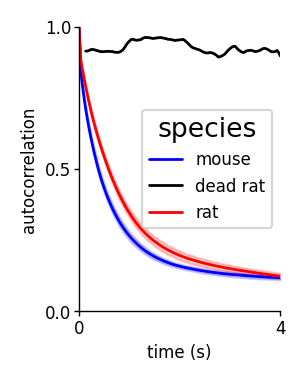

In [131]:
plt.figure(figsize=(1.3, 1.85))
sns.lineplot(data=mean_ac, x='time', y='ac', hue='species', palette=['blue', 'black', 'red'])
sns.despine()

ax = plt.gca()
ax.set_ylabel('autocorrelation')
ax.set_xlabel('time (s)')
ax.set_ylim(0, 1)
ax.set_xlim(0, 4)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0, 4])

# compute tau

In [133]:
import numpy as np

In [147]:
taus = np.linspace(300, 600, 30)
baselines = np.linspace(0.085, .185, 30)

mouse = mean_ac[mean_ac.species == 'mouse']
rat = mean_ac[mean_ac.species == 'rat']
dead = mean_ac[mean_ac.species == 'dead rat']

mouse_tau_df = compute_tau_df(mouse.groupby('time').ac.mean().values, taus, baselines)

taus = np.linspace(500, 1000, 30)
baselines = np.linspace(0.05, .2, 30)

rat_tau_df = compute_tau_df(rat.groupby('time').ac.mean().values, taus, baselines)

mouse_pivot = pd.pivot_table(mouse_tau_df, index='baseline', columns='tau', values='result')
rat_pivot = pd.pivot_table(rat_tau_df, index='baseline', columns='tau', values='result')

In [148]:
mouse_pivot_rounded = mouse_pivot.copy()
mouse_pivot_rounded.index = np.array(mouse_pivot_rounded.index).round(2)
mouse_pivot_rounded.columns = np.array(mouse_pivot_rounded.columns).round(2)

rat_pivot_rounded = rat_pivot.copy()
rat_pivot_rounded.index = np.array(rat_pivot_rounded.index).round(2)
rat_pivot_rounded.columns = np.array(rat_pivot_rounded.columns).round(2)

Text(0.5, 1.0, 'rat')

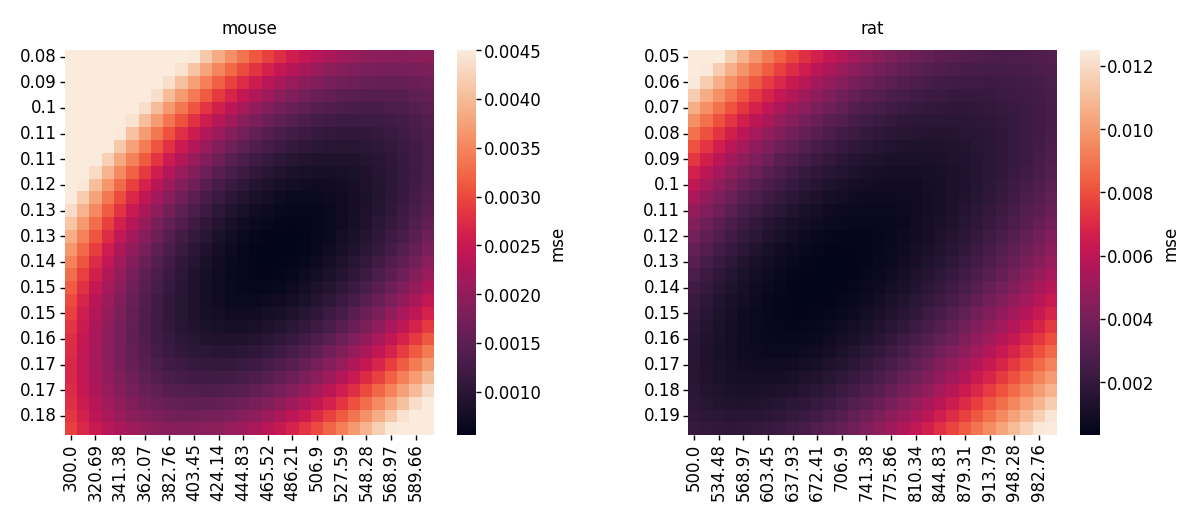

In [149]:
fig, ax = plt.subplots(1,2,figsize=(7,2.5), gridspec_kw={'wspace': .35})
sns.heatmap(mouse_pivot_rounded, ax=ax[0], fmt='.1f', vmax=.0045, cbar_kws={'label': 'mse'})
sns.heatmap(rat_pivot_rounded, ax=ax[1], fmt='.1f', vmax=.0125, cbar_kws={'label': 'mse'})

ax[0].set_title('mouse')
ax[1].set_title('rat')

In [150]:
mouse_optimal_tau = []

taus = np.linspace(300, 600, 30)
baselines = np.linspace(0.085, .185, 30)

for _mouse in mouse.animal.unique():
    tmp = mouse.query(f'animal == "{_mouse}"')
    _df = compute_tau_df(tmp.ac, taus, baselines)
    mouse_optimal_tau.append(_df[_df.result == _df.result.min()])

mouse_optimal_tau = pd.concat(mouse_optimal_tau)
mouse_optimal_tau['species'] = 'mouse'

In [151]:
rat_optimal_tau = []

taus = np.linspace(500, 1000, 30)
baselines = np.linspace(0.05, .2, 30)

for _rat in rat.animal.unique():
    tmp = rat.query(f'animal == "{_rat}"')
    _df = compute_tau_df(tmp.ac, taus, baselines)
    rat_optimal_tau.append(_df[_df.result == _df.result.min()])

rat_optimal_tau = pd.concat(rat_optimal_tau)
rat_optimal_tau['species'] = 'rat'

In [152]:
optimal_tau = pd.concat([mouse_optimal_tau, rat_optimal_tau])

/tmp/ipykernel_22800/967047088.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=optimal_tau, x='species', y='tau', palette='seismic', showfliers=False, boxprops={'alpha':.6})
/tmp/ipykernel_22800/967047088.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=optimal_tau, x='species', y='tau', palette='seismic', dodge=False, size=3)


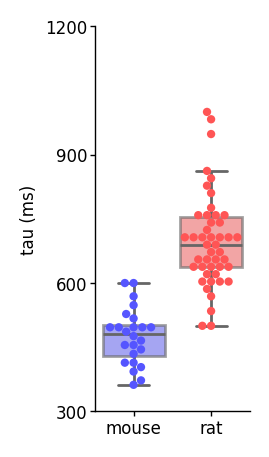

In [153]:
plt.figure(figsize=(1,2.5))

x='species'
y='tau'
palette='colorblind'
pair = [('mouse', 'rat')]

sns.boxplot(data=optimal_tau, x='species', y='tau', palette='seismic', showfliers=False, boxprops={'alpha':.6})
sns.swarmplot(data=optimal_tau, x='species', y='tau', palette='seismic', dodge=False, size=3)
sns.despine()
ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('tau (ms)')
ax.set_yticks([300, 600, 900, 1200])

In [160]:
optimal_tau[optimal_tau.species == 'mouse'].tau.median()

481.0344827586207

In [161]:
optimal_tau[optimal_tau.species == 'rat'].tau.median()

689.6551724137931